In [1]:
import json
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Hyperparameters

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 32
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
# Number of examples to use for training
training_size = 20000

### Download the dataset

In [3]:
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2023-01-16 04:44:50--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.26.128, 172.217.193.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.26.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2023-01-16 04:44:50 (99.2 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [4]:
with open('sarcasm.json', 'r') as f:
  datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])


### Split the dataset

In [5]:
training_sentences = sentences[0: training_size]
testing_sentences = sentences[training_size:]

training_labels = labels[0: training_size]
testing_labels = labels[training_size:]

### Preprocessing the train and test sets

In [6]:
from tensorflow.python import training
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

### Build and Compile the Model

In [7]:
import tensorflow as tf

gap1d_layer = tf.keras.layers.GlobalAveragePooling1D()

sample_array = np.array([[[10,2],[1,3],[1,1]]])

print(f'shape of sample_array = {sample_array.shape}')
print(f'sample array: {sample_array}')

output = gap1d_layer(sample_array)

print(f'output shape of gap1d_layer: {output.shape}')
print(f'output array of gap1d_layer: {output.numpy()}')




shape of sample_array = (1, 3, 2)
sample array: [[[10  2]
  [ 1  3]
  [ 1  1]]]
output shape of gap1d_layer: (1, 2)
output array of gap1d_layer: [[4 2]]


In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    # tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 16)            160000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train the Model

In [10]:
num_epochs = 30

# Train the model
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 12s - loss: 0.5570 - accuracy: 0.7103 - val_loss: 0.3907 - val_accuracy: 0.8360 - 12s/epoch - 20ms/step
Epoch 2/30
625/625 - 4s - loss: 0.3078 - accuracy: 0.8753 - val_loss: 0.3415 - val_accuracy: 0.8498 - 4s/epoch - 7ms/step
Epoch 3/30
625/625 - 4s - loss: 0.2322 - accuracy: 0.9092 - val_loss: 0.3389 - val_accuracy: 0.8559 - 4s/epoch - 6ms/step
Epoch 4/30
625/625 - 2s - loss: 0.1880 - accuracy: 0.9283 - val_loss: 0.3583 - val_accuracy: 0.8538 - 2s/epoch - 4ms/step
Epoch 5/30
625/625 - 2s - loss: 0.1561 - accuracy: 0.9422 - val_loss: 0.3890 - val_accuracy: 0.8453 - 2s/epoch - 4ms/step
Epoch 6/30
625/625 - 2s - loss: 0.1320 - accuracy: 0.9535 - val_loss: 0.4148 - val_accuracy: 0.8469 - 2s/epoch - 4ms/step
Epoch 7/30
625/625 - 2s - loss: 0.1127 - accuracy: 0.9618 - val_loss: 0.4560 - val_accuracy: 0.8419 - 2s/epoch - 4ms/step
Epoch 8/30
625/625 - 2s - loss: 0.0975 - accuracy: 0.9678 - val_loss: 0.4912 - val_accuracy: 0.8405 - 2s/epoch - 4ms/step
Epoch 9/30
625/625 - 

### Visualize the Results

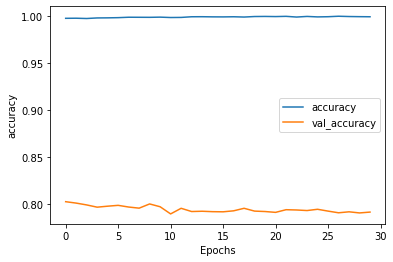

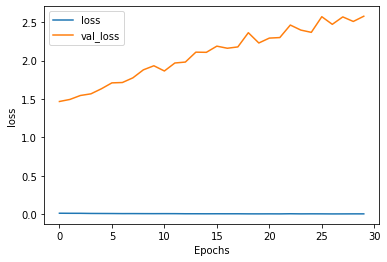

In [ ]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")


### Visualize Word Embeddings

In [13]:
reverse_word_index = tokenizer.index_word
embedding_layer = model.layers[0]
embedding_weights = embedding_layer.get_weights()[0]
embedding_weights

array([[ 0.02257977, -0.17617753, -0.21315879, ..., -0.02621152,
        -0.04025488,  0.10572527],
       [-0.02250357, -0.04602371, -0.05923855, ...,  0.00679713,
        -0.00858869,  0.00287158],
       [ 0.02351451,  0.13005531,  0.02385259, ...,  0.03258563,
        -0.09067637, -0.01575164],
       ...,
       [-0.3436778 , -0.35888833,  0.04109076, ..., -0.34033903,
         0.3277857 ,  0.31852552],
       [-0.00568846, -0.06825178, -0.19948287, ...,  0.0040519 ,
        -0.00311219,  0.02482016],
       [ 0.32867077,  0.24086699, -0.28929615, ...,  0.2753885 ,
        -0.22616348, -0.24763018]], dtype=float32)

In [14]:
print(embedding_weights.shape)

(10000, 16)


In [22]:
import io 

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):
  word_name = reverse_word_index[word_num]
  word_embedding = embedding_weights[word_num]
  # print(word_embedding.shape)
  # a = [str(x) for x in word_embedding]
  # print(a[0])
  out_m.write(word_name + "\n")
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

out_v.close()
out_m.close()

In [23]:
try:
  from google.colab import files
except ImportError:
  pass

# Download the files
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>